Here, for each fold and for with and without bias, we generate a new model 50 times. We then compare the distribution oflearned weights pairwise between iterations (and across model types) using EMD and model predictions using pearson correlation. This gives us a distribution of pairwise EMDs and pearsons we can then quantify whether they are statistically different. 


To control for a low EMD loss possibly being exaggerated due to enforced sparsity of the signaling network adjacency matrix (signaling network mask), we take two approaches:
1. We compare the EMD loss of the full matrix to that of a random matrix with the same enforced sparsity. To generate the random matrix, we draw from a random normal distribution with mean and std calculated across all iterations of non-masked weights across all models. 
2. We flatten the matrix with the coordinates that have enforced 0s removed.


In [1]:
import os
import math
import shutil
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import scipy
from scipy.stats import mannwhitneyu, pearsonr, ks_2samp
from scipy.spatial.distance import jensenshannon
from statsmodels.stats.multitest import multipletests
from sklearn.model_selection import train_test_split

import itertools

import torch
from geomloss import SamplesLoss


import matplotlib.pyplot as plt
from plotnine import ggplot, aes, geom_line, theme_bw, theme, geom_point, geom_hline, annotate, scale_y_log10
import plotnine as p9
import seaborn as sns
import gc


[KeOps] Warning : There were warnings or errors :
<stdin>:1:10: fatal error: cuda.h: No such file or directory
compilation terminated.

[KeOps] Warning : 
    The location of Cuda header files cuda.h and nvrtc.h could not be detected on your system.
    You must determine their location and then define the environment variable CUDA_PATH,
    either before launching Python or using os.environ before importing keops. For example
    if these files are in /vol/cuda/10.2.89-cudnn7.6.4.38/include you can do :
      import os
      os.environ['CUDA_PATH'] = '/vol/cuda/10.2.89-cudnn7.6.4.38'
    
[KeOps] Compiling cuda jit compiler engine ... 
[KeOps] Warning : There were warnings or errors :
/nobackup/users/hmbaghda/Software/miniforge3/envs/scLEMBAS/lib/python3.11/site-packages/keopscore/binders/nvrtc/nvrtc_jit.cpp:16:10: fatal error: cuda.h: No such file or directory
 #include <cuda.h>
          ^~~~~~~~
compilation terminated.

OK
[pyKeOps] Compiling nvrtc binder for python ... 
[KeOps] W

In [2]:
sclembas_path = os.path.join(os.path.abspath('../../LEMBAS'))

import sys
sys.path.insert(1, sclembas_path)

from LEMBAS.model.bionetwork import format_network, SignalingModel
from LEMBAS.benchmarking_version.benchmark_train import train_signaling_model
import LEMBAS.utilities as utils
from LEMBAS import plotting, io

In [3]:
n_cores = 20
utils.set_cores(n_cores)

seed = 888
if seed:
    torch.use_deterministic_algorithms(True)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    utils.set_seeds(seed = seed)
    
device = 'cuda' if torch.cuda.is_available() else 'cpu'

data_path = '/nobackup/users/hmbaghda/LEMBAS_benchmark/'

Load and format the data:

In [4]:
def inverse_sigmoid(y):
    return np.log(y / (1 - y))

In [5]:
net = pd.read_csv('https://zenodo.org/records/10815391/files/macrophage_network.tsv', sep = '\t', index_col = False)
ligand_input = pd.read_csv('https://zenodo.org/records/10815391/files/macrophage_ligands.tsv', sep = '\t', index_col = 0)
tf_output = pd.read_csv('https://zenodo.org/records/10815391/files/macrophage_TFs.tsv', sep='\t', low_memory=False, index_col=0)

untransformed_tf_output = inverse_sigmoid(tf_output)


In [6]:
stimulation_label = 'stimulation'
inhibition_label = 'inhibition'
weight_label = 'mode_of_action'
source_label = 'source'
target_label = 'target'
# Format network
net = format_network(net, weight_label = weight_label, stimulation_label = stimulation_label, inhibition_label = inhibition_label)

# benchmarking specific files
# torch.save(mod.signaling_network.mask.detach(), 
#            os.path.join(data_path, 'interim', 'mask.pt'))

mask = torch.load(os.path.join(data_path, 'interim', 'mask.pt')).to_dense()
n_nodes = 1128


In [7]:
nodes = net[[source_label, target_label]].values.flatten()
tf_output = tf_output[[col for col in tf_output.columns if col in nodes]]
untransformed_tf_output = untransformed_tf_output[tf_output.columns]


Set up the model parameters:

In [8]:
projection_amplitude_in = 3
projection_amplitude_out = 1.2
# other parameters
bionet_params = {'target_steps': 100, 'max_steps': 150, 'exp_factor':50, 'tolerance': 1e-5, 'leak':1e-2} # fed directly to model

# training parameters
lr_params = {'max_iter': 1000, 
            'learning_rate': 2e-3}
other_params = {'batch_size': 10, 'noise_level': 10, 'gradient_noise_level': 1e-9}
regularization_params = {'param_lambda_L2': 1e-6, 'moa_lambda_L1': 0.1, 'ligand_lambda_L2': 1e-5, 'uniform_lambda_L2': 1e-4, 
                'uniform_max': 1/projection_amplitude_out, 'spectral_loss_factor': 1e-5}
spectral_radius_params = {'n_probes_spectral': 5, 'power_steps_spectral': 5, 'subset_n_spectral': 5}
target_spectral_radius = 0.8
hyper_params = {**lr_params, **other_params, **regularization_params, **spectral_radius_params} # fed into training function



Set up training parameters:

In [9]:
iter_dicts = [
    {'uniform': 1, 'L2_or_rand': 1, 'ProjectOutput_bias': 1},
    {'uniform': 1, 'L2_or_rand': 1, 'ProjectOutput_bias': 0},
              ]
            
bias_map = {0: untransformed_tf_output.copy(), # new implementation can handle negatives
            1: tf_output.copy()}
dict_to_bench_default = {'test_time': 0}

Find a CV split where there is no "zero-shot" learning (all individual ligands have been seen before):

Train on all samples:

In [10]:
samples = ligand_input.index.tolist()
k_folds = {}
k_folds[0] = {'train': samples, 'test': None}


# k_folds = {}
# samples = ligand_input.index.tolist()

# zero_shot_samples = []

# k = 0
# for sample in samples:
#     samples_ = samples.copy()
#     samples_.remove(sample)
    
#     X_train = ligand_input.loc[samples_, :]
    
#     X_test = pd.DataFrame(ligand_input.loc[sample, :]).T
#     y_test = pd.DataFrame(tf_output.loc[sample, :]).T    
    
#     test_ligands = X_test.columns[(X_test != 0).any()]
#     train_ligands = X_train.columns[(X_train != 0).any()]

#     if len(set(test_ligands).difference(train_ligands)) != 0: # zero-shot
#         zero_shot_samples.append(sample)
#     else: 
#         k_folds[k] = {'train': samples_, 
#                      'test': sample}
#         k += 1

Train and test the model:

In [11]:
def _train_model(mod, dict_to_bench, hyper_params, fn = None):
#     mod.X_in = mod.df_to_tensor(mod.X_in)
#     mod.y_out = mod.df_to_tensor(mod.y_out)

    
    mod.input_layer.weights.requires_grad = False # don't learn scaling factors for the ligand input concentrations
    mod.signaling_network.prescale_weights(target_radius = target_spectral_radius) # spectral radius

    # loss and optimizer
    loss_fn = torch.nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam

    #
    res = train_signaling_model(mod, 
                                optimizer, 
                                loss_fn, 
                                reset_epoch = 200, 
                                hyper_params = hyper_params, 
                                train_seed = None, 
                                verbose = False,
                                dict_to_bench=dict_to_bench, 
                               train_split_frac = {'train': 1, 'test': None, 'validation': None})

    mod, cur_loss, cur_eig, mean_loss, stats, _, _, _, _, _, _ = res
    if fn is not None:
#         torch.save(mod.state_dict(), fn)
        io.write_pickled_object(mod, fn)
        gradients = {name: param.grad for name, param in mod.named_parameters()}
        fn_grad = fn.replace('.pickle', '_gradients.pickle')
        io.write_pickled_object(gradients, fn_grad)
    return mod #, stats_df

def pairwise_pearson_correlation(X, Y):
    # Center the data by subtracting the mean of each row
    X_centered = X - X.mean(axis=1, keepdims=True)
    Y_centered = Y - Y.mean(axis=1, keepdims=True)
    
    # Compute the dot product of the centered data
    dot_product = np.dot(X_centered, Y_centered.T)
    
    # Compute the norm (standard deviation) of each row
    X_norm = np.linalg.norm(X_centered, axis=1)
    Y_norm = np.linalg.norm(Y_centered, axis=1)
    
    # Normalize the dot product by the outer product of the norms
    correlation_matrix = dot_product / np.outer(X_norm, Y_norm)
    
    return correlation_matrix

def get_upper_triangle(array):
    rows, cols = np.triu_indices(array.shape[0], k=1)
    ut = array[rows, cols]
    return ut


def _evaluate_model(mod, X_test, y_test):
    X_test = mod.df_to_tensor(X_test)
    if len(X_test.shape) == 1: # 1 sample
        X_test = X_test.reshape(1,-1)

    tf_order = {k: v for k, v in mod.node_idx_map.items() if k in tf_output.columns}
    y_test = mod.df_to_tensor(y_test[sorted(tf_order, key=tf_order.get)])
    y_test = y_test.reshape(1,-1)

    mod.eval()
    with torch.inference_mode():
        Y_hat, _ = mod(X_test)
#         loss_fn = torch.nn.MSELoss(reduction='mean')
#         mse_loss = loss_fn(Y_hat, y_test).detach().cpu().numpy().item()
#         corr_row = torch.nanmean(pearson_corr(Y_hat, y_test, axis=0)).cpu().numpy().item()

    return Y_hat.detach().cpu().numpy()


def shift_normalize(weights, global_min):
    weights += global_min
    weights = weights/np.sum(weights, axis=1, keepdims=True)#weights / row_sums[:, np.newaxis]
    return weights

def transform_to_probability_distribution(weights_0, weights_1, weights_rand):
    weights_0 = weights_0.cpu().numpy()
    weights_1 = weights_1.cpu().numpy()
    weights_rand = weights_rand.cpu().numpy()

    # shift
    pc = 1e-5
    global_min = abs(min(np.min(weights_0), np.min(weights_1), np.min(weights_rand))) + pc
    weights_0 = shift_normalize(weights_0, global_min)
    weights_1 = shift_normalize(weights_1, global_min)
    weights_rand = shift_normalize(weights_rand, global_min)
    
    return weights_0, weights_1, weights_rand




In [12]:
# for iter_dict in iter_dicts:
#     iter_name = '-'.join(['^'.join([k,str(v)]) for k,v in iter_dict.items()])
#     for fn in [os.path.join(data_path, 'interim', iter_name + '_weights.pt'), 
#               os.path.join(data_path, 'interim', iter_name + '_Yhat.npy')]:
#         print('rm ' + fn)
# print('rm ' + os.path.join(data_path, 'processed', 'iter_bias.csv'))
# print('')

rm /nobackup/users/hmbaghda/LEMBAS_benchmark/interim/uniform^0-L2_or_rand^0-ProjectOutput_bias^1_weights.pt
rm /nobackup/users/hmbaghda/LEMBAS_benchmark/interim/uniform^0-L2_or_rand^0-ProjectOutput_bias^1_Yhat.npy
rm /nobackup/users/hmbaghda/LEMBAS_benchmark/interim/uniform^0-L2_or_rand^0-ProjectOutput_bias^0_weights.pt
rm /nobackup/users/hmbaghda/LEMBAS_benchmark/interim/uniform^0-L2_or_rand^0-ProjectOutput_bias^0_Yhat.npy
rm /nobackup/users/hmbaghda/LEMBAS_benchmark/processed/iter_bias.csv



# Iterate

In [12]:
n_iter = 50

In [13]:
k_folds_res = pd.read_csv(os.path.join(data_path, 'processed', 'benchmark_cv.csv'), index_col = 0)

# combs = pd.DataFrame(columns = ['uniform', 'L2_or_rand', 'bias'], 
#             data = [[int(i[-1]) for i in x.split('-')[1:]] for x in k_folds_res.index])
# k_folds_res.reset_index(drop = True, inplace = True)
# k_folds_res = pd.concat([k_folds_res, combs], axis = 1)
k_folds_res['cond'] = k_folds_res[['uniform', 'L2_or_rand', 'ProjectOutput_bias']].astype(int).astype(str).agg('^'.join, axis=1).tolist()
k_folds_res['cond'] = pd.Categorical(k_folds_res['cond'], 
                                     categories=['1^1^1', '0^1^1', '1^0^1', '1^1^0', '0^0^1'], 
                                     ordered=True)


In [7]:
# fns = [os.path.join(data_path, 'processed', 'iter_bias.csv')]
# for iter_dict in iter_dicts:
#     iter_name = '-'.join(['^'.join([k,str(v)]) for k,v in iter_dict.items()])
#     fns.append(os.path.join(data_path, 'interim', iter_name + '_weights.pt'))

# for fn in fns:
#     print('rm ' + fn)
# print('')

rm /nobackup/users/hmbaghda/LEMBAS_benchmark/processed/iter_bias.csv
rm /nobackup/users/hmbaghda/LEMBAS_benchmark/interim/uniform^0-L2_or_rand^0-ProjectOutput_bias^0_weights.pt
rm /nobackup/users/hmbaghda/LEMBAS_benchmark/interim/uniform^0-L2_or_rand^0-ProjectOutput_bias^1_weights.pt



In [18]:
if os.path.isfile(os.path.join(data_path, 'processed', 'iter_bias.csv')):
    res_all = pd.read_csv(os.path.join(data_path, 'processed', 'iter_bias.csv'), index_col = 0)
    curr_k = 0#res_all['fold'].max() + 1
else:
    res_all = None
    curr_k = 0

Each row of res all is one fold. Each column is a pairwise EMD comparison between either within one of the models or betwen them (stacked row-wise).

In [23]:
for k in k_folds:
    if k >= curr_k:
        hyper_params_k = hyper_params.copy()
        
        l2 = 1e-6
#         l2 = k_folds_res.loc[k_folds_res.k == k, 'param_lambda_L2'].unique().tolist()
#         if len(l2) != 1:
#             raise ValueError('Something went wrong with lambda L2 selection')
#         else:
#             l2 = l2[0]
#         hyper_params_k['param_lambda_L2']=l2
    
        for iter_dict in iter_dicts:
            iter_name = '-'.join(['^'.join([k,str(v)]) for k,v in iter_dict.items()])
            
            
            if os.path.isfile(os.path.join(data_path, 'interim', iter_name + '_weights.pt')):
                weights_iter = torch.load(os.path.join(data_path, 'interim', iter_name + '_weights.pt')).to_dense()
#                 Y_hat_iter = np.load(os.path.join(data_path, 'interim', iter_name + '_Yhat.npy'))
#                 if Y_hat.shape[0] != weights_iter.shape[0]:
#                     raise ValueError('Something went wrong on iterating')
            else:
                weights_iter = torch.tensor([])            
            
            for i in range(weights_iter.shape[0], n_iter):
                po_bias = iter_dict['ProjectOutput_bias']
                tf_output = bias_map[po_bias]

                mod = SignalingModel(net = net,
                                     X_in = ligand_input.loc[k_folds[k]['train'], :],
                                     y_out = tf_output.loc[k_folds[k]['train'], :],
                                     projection_amplitude_in = projection_amplitude_in, 
                                     projection_amplitude_out = projection_amplitude_out,
                                     weight_label = weight_label, source_label = source_label, target_label = target_label,
                                     bionet_params = bionet_params,
                                     dtype = torch.float32, device = device, seed = seed + i)

                dict_to_bench = {**dict_to_bench_default, **iter_dict}
                dict_to_bench['name'] = iter_name
#                 fn = None if po_bias else os.path.join(data_path, 'processed', dict_to_bench['name'] + '.pickle')
                mod = _train_model(mod = mod, 
                                   dict_to_bench=dict_to_bench,
                                   hyper_params = hyper_params_k,
                                   fn = None)
    
                weights = mod.signaling_network.weights.data.detach().flatten()
#                 Y_hat = _evaluate_model(mod = mod, 
#                                              X_test = ligand_input.loc[k_folds[k]['test'], :], 
#                                              y_test = tf_output.loc[k_folds[k]['test'], :])
            
                if i == 0:
                    weights_iter = weights.unsqueeze(0)
#                     Y_hat_iter = Y_hat.copy()
                else:
                    weights_iter = torch.cat((weights_iter, weights.unsqueeze(0)), dim=0)
#                     Y_hat_iter = np.vstack((Y_hat_iter, Y_hat))
                torch.save(weights_iter, os.path.join(data_path, 'interim', iter_name + '_weights.pt'))
#                 np.save(os.path.join(data_path, 'interim', iter_name + '_Yhat.npy'), Y_hat_iter)
            
                del mod#, Y_hat
                torch.cuda.empty_cache()
                gc.collect()
        
        # collect metrics
        iter_res = {}
        for iter_dict in iter_dicts:
            iter_name = '-'.join(['^'.join([k,str(v)]) for k,v in iter_dict.items()])
            iter_res[iter_name] = {}

            iter_res[iter_name]['weights'] = torch.load(os.path.join(data_path, 'interim', iter_name + '_weights.pt')).to_dense()
        #             iter_res[iter_name]['Y_hat'] = np.load(os.path.join(data_path, 'interim', iter_name + '_Yhat.npy'))

        for comb in itertools.combinations(iter_res, 2):
            weights_0 = iter_res[comb[0]]['weights']
            weights_1 = iter_res[comb[1]]['weights']

            # generate the random matrix
            weights_all = torch.cat((weights_0, weights_1), dim = 0)
            weights_all = weights_all[:, ~mask.flatten()].flatten()
            # max_val, min_val = torch.max(weights_all), torch.min(weights_all)
            mean_val = torch.mean(weights_all)
            std_val = torch.std(weights_all)
            for i_rand in range(n_iter):
                torch.manual_seed(seed + i_rand)
                weights_rand_ = mean_val + std_val * torch.randn(n_nodes, n_nodes, device = device)
                weights_rand_.data.masked_fill_(mask = mask, value = 0.0)
                if i_rand == 0:
                    weights_rand = weights_rand_.flatten().unsqueeze(0)
                else:
                    weights_rand = torch.cat((weights_rand, weights_rand_.flatten().unsqueeze(0)), dim=0)
            
            # apply mask to remove sparsity
            weights_0_ns = weights_0[:, ~mask.flatten()]
            weights_1_ns = weights_1[:, ~mask.flatten()]
            weights_rand_ns = weights_rand[:, ~mask.flatten()]
            
            # convert to probability distribution for JS metric
            weights_0_prob, weights_1_prob, weights_rand_prob = transform_to_probability_distribution(weights_0, weights_1, weights_rand)
            weights_0_prob_ns, weights_1_prob_ns, weights_rand_prob_ns = transform_to_probability_distribution(weights_0_ns, weights_1_ns, weights_rand_ns)

            emd_loss_fn = SamplesLoss("sinkhorn", p=2, blur=0.05).to(weights_0.device)

            within_0_w, within_1_w, cross_w, cross_rand_0, cross_rand_1 = [], [], [], [], []
            within_0_w_ns, within_1_w_ns, cross_w_ns, cross_rand_0_ns, cross_rand_1_ns = [], [], [], [], []
            within_0_w_ks, within_1_w_ks, cross_w_ks, cross_rand_0_ks, cross_rand_1_ks = [], [], [], [], []
            within_0_w_ks_ns, within_1_w_ks_ns, cross_w_ks_ns, cross_rand_0_ks_ns, cross_rand_1_ks_ns = [], [], [], [], []
            within_0_w_js, within_1_w_js, cross_w_js, cross_rand_0_js, cross_rand_1_js = [], [], [], [], []
            within_0_w_js_ns, within_1_w_js_ns, cross_w_js_ns, cross_rand_0_js_ns, cross_rand_1_js_ns = [], [], [], [], []
            for j_0, j_1 in (itertools.combinations(range(n_iter), r = 2)):
                # all values in matrix format - emd
                within_0_w += [emd_loss_fn(weights_0[j_0,:].reshape(n_nodes, n_nodes),
                                           weights_0[j_1,:].reshape(n_nodes, n_nodes)).detach().item()]
                within_1_w += [emd_loss_fn(weights_1[j_0,:].reshape(n_nodes, n_nodes),
                                       weights_1[j_1,:].reshape(n_nodes, n_nodes)).detach().item()]

                # flattened values disregarding masked 0s - emd
                within_0_w_ns += [emd_loss_fn(weights_0_ns[j_0,:].unsqueeze(0),
                                                      weights_0_ns[j_1,:].unsqueeze(0)).detach().item()]
                within_1_w_ns += [emd_loss_fn(weights_1_ns[j_0,:].unsqueeze(0),
                                                      weights_1_ns[j_1,:].unsqueeze(0)).detach().item()]

                # ks test
                within_0_w_ks += [ks_2samp(weights_0[j_0,:].cpu().numpy(), 
                                           weights_0[j_1,:].cpu().numpy()).statistic]
                within_1_w_ks += [ks_2samp(weights_1[j_0,:].cpu().numpy(), 
                                           weights_1[j_1,:].cpu().numpy()).statistic]

                within_0_w_ks_ns += [ks_2samp(weights_0_ns[j_0,:].cpu().numpy(), 
                                           weights_0_ns[j_1,:].cpu().numpy()).statistic]
                within_1_w_ks_ns += [ks_2samp(weights_1_ns[j_0,:].cpu().numpy(), 
                                           weights_1_ns[j_1,:].cpu().numpy()).statistic]
                
                # js
                within_0_w_js.append(jensenshannon(weights_0_prob[j_0,:], weights_0_prob[j_1,:]))
                within_1_w_js.append(jensenshannon(weights_1_prob[j_0,:], weights_1_prob[j_1,:]))
                
                within_0_w_js_ns.append(jensenshannon(weights_0_prob_ns[j_0,:], weights_0_prob_ns[j_1,:]))
                within_1_w_js_ns.append(jensenshannon(weights_1_prob_ns[j_0,:], weights_1_prob_ns[j_1,:]))


            for j_0, j_1 in (itertools.product(range(n_iter), repeat=2)):
                # emd
                cross_w += [emd_loss_fn(weights_0[j_0,:].reshape(n_nodes, n_nodes),
                                           weights_1[j_1,:].reshape(n_nodes, n_nodes)).detach().item()]
                cross_rand_0 += [emd_loss_fn(weights_0[j_0,:].reshape(n_nodes, n_nodes),
                                           weights_rand[j_1,:].reshape(n_nodes, n_nodes)).detach().item()]
                cross_rand_1 += [emd_loss_fn(weights_1[j_0,:].reshape(n_nodes, n_nodes),
                                           weights_rand[j_1,:].reshape(n_nodes, n_nodes)).detach().item()]

                cross_w_ns += [emd_loss_fn(weights_0_ns[j_0,:].unsqueeze(0),
                                           weights_1_ns[j_1,:].unsqueeze(0)).detach().item()]
                cross_rand_0_ns += [emd_loss_fn(weights_0_ns[j_0,:].unsqueeze(0),
                                           weights_rand_ns[j_1,:].unsqueeze(0)).detach().item()]
                cross_rand_1_ns += [emd_loss_fn(weights_1_ns[j_0,:].unsqueeze(0),
                                           weights_rand_ns[j_1,:].unsqueeze(0)).detach().item()] 

                # ks test

                cross_w_ks += [ks_2samp(weights_0[j_0,:].cpu().numpy(), 
                       weights_1[j_1,:].cpu().numpy()).statistic]
                cross_rand_0_ks += [ks_2samp(weights_0[j_0,:].cpu().numpy(), 
                                       weights_rand[j_1,:].cpu().numpy()).statistic]
                cross_rand_1_ks += [ks_2samp(weights_1[j_0,:].cpu().numpy(), 
                                       weights_rand[j_1,:].cpu().numpy()).statistic]

                cross_w_ks_ns += [ks_2samp(weights_0_ns[j_0,:].cpu().numpy(), 
                       weights_1[j_1,:][~mask.flatten()].cpu().numpy()).statistic]
                cross_rand_0_ks_ns += [ks_2samp(weights_0_ns[j_0,:].cpu().numpy(), 
                                       weights_rand_ns[j_1,:].cpu().numpy()).statistic]
                cross_rand_1_ks_ns += [ks_2samp(weights_1_ns[j_0,:].cpu().numpy(), 
                                       weights_rand_ns[j_1,:].cpu().numpy()).statistic]
                
                # js
                cross_w_js.append(jensenshannon(weights_0_prob[j_0,:], weights_1_prob[j_1,:]))
                cross_rand_0_js.append(jensenshannon(weights_0_prob[j_0,:], weights_rand_prob[j_1,:]))
                cross_rand_1_js.append(jensenshannon(weights_1_prob[j_0,:], weights_rand_prob[j_1,:]))
                
                cross_w_js_ns.append(jensenshannon(weights_0_prob_ns[j_0,:], weights_1_prob_ns[j_1,:]))
                cross_rand_0_js_ns.append(jensenshannon(weights_0_prob_ns[j_0,:], weights_rand_prob_ns[j_1,:]))
                cross_rand_1_js_ns.append(jensenshannon(weights_1_prob_ns[j_0,:], weights_rand_prob_ns[j_1,:]))



        #             Y_hat_0 = iter_res[comb[0]]['Y_hat']
        #             Y_hat_1 = iter_res[comb[1]]['Y_hat']
        #             cross_y = pairwise_pearson_correlation(Y_hat_0, Y_hat_1).flatten()
        #             within_0_y = get_upper_triangle(pairwise_pearson_correlation(Y_hat_0, Y_hat_0))
        #             within_1_y = get_upper_triangle(pairwise_pearson_correlation(Y_hat_1, Y_hat_1))
            res = pd.DataFrame(
                {
                    'weights': within_0_w + within_1_w + cross_w + cross_rand_0 + cross_rand_1, 
                    'ks_statistic': within_0_w_ks + within_1_w_ks + cross_w_ks + cross_rand_0_ks + cross_rand_1_ks,
                    'js': within_0_w_js + within_1_w_js + cross_w_js + cross_rand_0_js + cross_rand_1_js,

                    'weights_nosparsity': within_0_w_ns + within_1_w_ns + cross_w_ns + cross_rand_0_ns + cross_rand_1_ns,
                    'ks_statistic_nosparsity': within_0_w_ks_ns + within_1_w_ks_ns + cross_w_ks_ns + cross_rand_0_ks_ns + cross_rand_1_ks_ns, 
                    'js_nosparsity': within_0_w_js_ns + within_1_w_js_ns + cross_w_js_ns + cross_rand_0_js_ns + cross_rand_1_js_ns
                }
            ).T 


                              #'output': list(within_0_y) + list(within_1_y) + list(cross_y)}).T
            

#             res['comparison'] = '-'.join(comb)
#             res['fold'] = k
            res.reset_index(inplace = True)

        if res_all is None:
            res_all = res
        else:
            res_all = pd.concat([res_all, res], axis = 0).reset_index(drop = False)
        res_all.to_csv(os.path.join(data_path, 'processed', 'iter_bias.csv'))
        

just before
[[ 596  649  732 ...  443  539  623]
 [   0    0    1 ... 1127 1127 1127]]
cuda


training: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.24it/s]


just before
[[ 596  649  732 ...  443  539  623]
 [   0    0    1 ... 1127 1127 1127]]
cuda


training: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.26it/s]


just before
[[ 596  649  732 ...  443  539  623]
 [   0    0    1 ... 1127 1127 1127]]
cuda


training: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.20it/s]


just before
[[ 596  649  732 ...  443  539  623]
 [   0    0    1 ... 1127 1127 1127]]
cuda


training: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.10it/s]


just before
[[ 596  649  732 ...  443  539  623]
 [   0    0    1 ... 1127 1127 1127]]
cuda


training: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.05it/s]


just before
[[ 596  649  732 ...  443  539  623]
 [   0    0    1 ... 1127 1127 1127]]
cuda


training: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.11it/s]


just before
[[ 596  649  732 ...  443  539  623]
 [   0    0    1 ... 1127 1127 1127]]
cuda


training: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.15it/s]


# Visualize/quantify

In [35]:
n_iter = 50

In [36]:
def cohen_d(vector_1, vector_2):
    # Calculate the means of the two vectors
    mean1 = np.mean(vector_1)
    mean2 = np.mean(vector_2)

    # Calculate the standard deviations of the two vectors
    std1 = np.std(vector_1, ddof=1)
    std2 = np.std(vector_2, ddof=1)

    # Calculate the pooled standard deviation
    n1 = len(vector_1)
    n2 = len(vector_2)
    pooled_std = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))

    return (mean1 - mean2) / pooled_std

In [37]:
res_all = pd.read_csv(os.path.join(data_path, 'processed', 'iter_bias.csv'), index_col = 0)
res_all.rename(columns = {'index': 'assessment'}, inplace = True)

# if res_all.comparison.nunique() != 1:
#     raise ValueError('Only written for the one comparison')

In [38]:
assessment_map = {'weights': 'EMD', 
                 'weights_nosparsity': 'EMD', 
                 'ks_statistic': 'KS Statistic', 
                 'ks_statistic_nosparsity': 'KS Statistic', 
                 'js': 'Jensen-Shannon Distance', 
                 'js_nosparsity': 'Jensen-Shannon Distance'}
title_map = {'weights': 'Signaling Weights (Matrix)', 
            'weights_nosparsity': 'Signaling Weights (Flattened, No Sparsity)', 
            'ks_statistic': 'Signaling Weights (Flattened)', 
            'ks_statistic_nosparsity': 'Signaling Weights (Flattened, No Sparsity)', 
                 'js': 'Signaling Weights (Flattened)', 
                 'js_nosparsity': 'Signaling Weights (Flattened, No Sparsity)'}

comparisons = ['within no bias', 'within bias', 'between', 
              'between no bias random', 'between bias random']
metric_cats = [comparisons[0]]*len(list((itertools.combinations(range(n_iter), r = 2)))) + \
[comparisons[1]]*len(list((itertools.combinations(range(n_iter), r = 2)))) + \
[comparisons[2]]*len(list((itertools.product(range(n_iter), repeat=2)))) + \
[comparisons[3]]*len(list((itertools.product(range(n_iter), repeat=2)))) + \
[comparisons[4]]*len(list((itertools.product(range(n_iter), repeat=2))))
metric_cats = pd.Categorical(metric_cats, ordered=True, categories=comparisons)

xlabels = ['within: no bias', 'within: bias', 
         'between: \n (no bias, bias)', 'between: \n (no bias, random)', 
         'between: \n (bias, random)']

In [39]:
fdr_thresh = 0.1

''

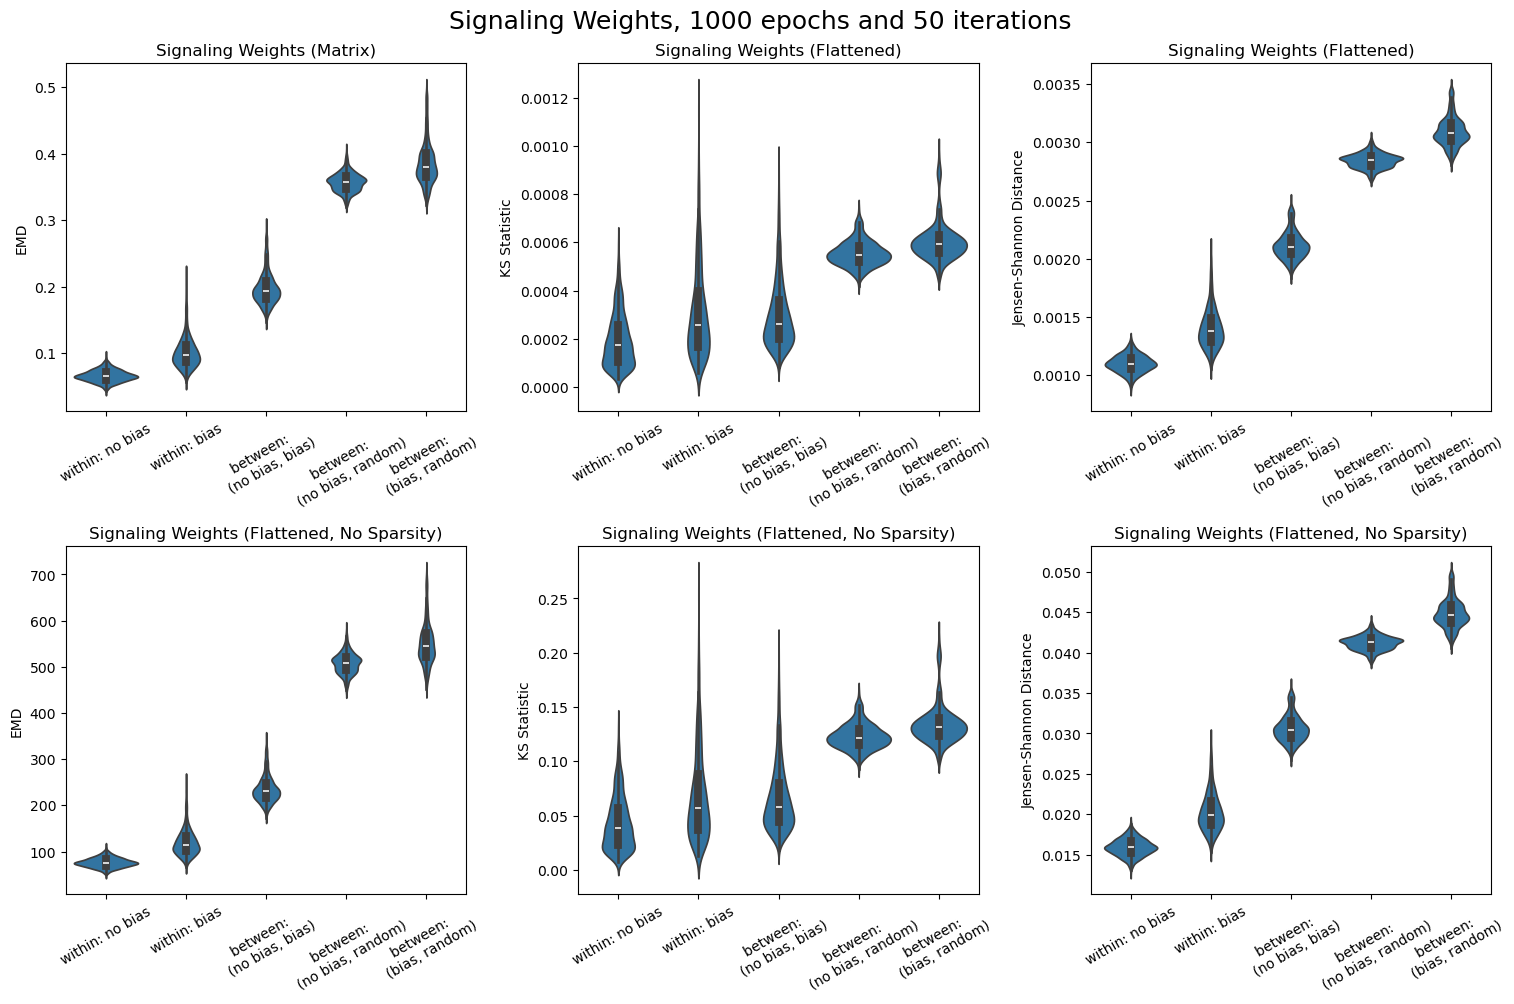

In [40]:
ncols = 3#res_all.assessment.nunique()
nrows = 2
fig, axes = plt.subplots(ncols = ncols, nrows = nrows,
                         figsize = (ncols*5.1,nrows*5.1)) 
ax = axes.flatten()

assessment = 'weights'
for i, assessment in enumerate(res_all.assessment.unique()):
    viz_df = res_all[res_all.assessment == assessment].drop(columns = ['assessment']).T
    viz_df.columns = [assessment_map[assessment]]
    viz_df['Comparison'] = metric_cats
    
    sns.violinplot(y = assessment_map[assessment], x = 'Comparison', data = viz_df, ax = ax[i])
    ax[i].set_title(title_map[assessment])
    ax[i].set_xlabel('')
    ax[i].set_xticklabels(xlabels, rotation=30, ha='center')
    
    # get stats
    stats_df = pd.DataFrame(columns = ['comb', 'MWU_pval', 'cohen_d'])
    comparisons_ = itertools.combinations(viz_df.Comparison.unique(), 2)
    for comb in comparisons_:
        l0 = viz_df[viz_df.Comparison == comb[0]][assessment_map[assessment]].tolist()
        l1 = viz_df[viz_df.Comparison == comb[1]][assessment_map[assessment]].tolist()
        _, mwu_pval = mannwhitneyu(l0, l1)
        stats_df.loc[stats_df.shape[0], :] = [comb, mwu_pval, cohen_d(l0, l1)]
    _, fdrs, _, _ = multipletests(stats_df.MWU_pval, method='fdr_bh')
    stats_df['BH_FDR'] = fdrs 
    
    effect_size = stats_df.cohen_d.tolist()

    y_max = viz_df[assessment_map[assessment]].max()
    x_pos = dict(zip(comparisons, range(len(comparisons))))
    annotation_y_offset = 0.01
    annotation_y_offset_2 = 0.005

#     start_vals = [(y_max*0.9 + (i*0.0003)) for i in range(len(fdrs))]
#     comparison_heights = [y_max + i for i in start_vals]  # Stagger the bars
#     annotation_heights = [y_max + i + (i*0.1) for i in start_vals]
#     effect_size_heights = [y_max + i + (i*0.1) for i in start_vals]  # Stagger effect sizes
#     counter = 0
#     for j, ((comp1, comp2), p_value, effect) in enumerate(zip(itertools.combinations(viz_df.Comparison.unique(), 2)
#                                                               , fdrs, effect_size)):
#         x_mid = (x_pos[comp1] + x_pos[comp2]) / 2

#         significance = ""
#         if p_value <= (fdr_thresh/1e3):
#             significance = "****"
#         elif p_value <= (fdr_thresh/1e2):
#             significance = "***"
#         elif p_value <= (fdr_thresh/10):
#             significance = "**"
#         elif p_value <= fdr_thresh:
#             significance = "*"

# #         significance = '**'
#         if significance != '':
#             y_pos = y_max + (counter * annotation_y_offset)
#             ax[i].plot([x_pos[comp1], x_pos[comp2]], [y_pos, y_pos], color='black', lw=1.5)
#             annotation_text = "Cohen's D: {:.2f}, ".format(effect) + significance #'Cohen'f"Cohen's d={effect:.2f}"
#             ax[i].text(x_mid, y_pos + annotation_y_offset_2, annotation_text, ha='center', color='black', fontsize=10)
#             counter += 1
#     # Step 5: Add a significance legend
#     handles = [plt.Line2D([0], [0], color='black', marker='', linestyle='None', label='FDR <= 0.1 *'),
#            plt.Line2D([0], [0], color='black', marker='', linestyle='None', label='FDR <= 0.01 **'),
#            plt.Line2D([0], [0], color='black', marker='', linestyle='None', label='FDR <= 0.001 ***'),
#            plt.Line2D([0], [0], color='black', marker='', linestyle='None', label='FDR <= 1e-4 ****')]  
    
    

fig.suptitle('Signaling Weights, {} epochs and {} iterations'.format(hyper_params['max_iter'], n_iter), 
            fontsize = 18)
fig.tight_layout()
;